# Jewish Claims Conference Grants Data

In [1]:
import requests
import urllib.request
import pandas as pd
import re
from bs4 import BeautifulSoup as bs

## Data collection

The JCC publishes only the latest grants DB (2017) on its website. Wayback machine holds data for 2013-2016.

In [2]:
# a dictionary with the URL of each year
yearly_dbs = {2017: 'http://www.claimscon.org/what-we-do/allocations/grants-database-2017/',
              2016: 'https://web.archive.org/web/20170607183332/http://www.claimscon.org/what-we-do/allocations/grants-database-2016/',
              2015: 'https://web.archive.org/web/20170313201053/http://www.claimscon.org/what-we-do/allocations/grants-database-2015/',
              2014: 'https://web.archive.org/web/20150211162230/http://www.claimscon.org/what-we-do/allocations/grants-database-2014/',
              2013: 'https://web.archive.org/web/20131218215323/http://www.claimscon.org/what-we-do/allocations/allocations-2013/'}

In [3]:
parsed_pages = {}

# iterate on the URLs, request the page and parse it
for year in yearly_dbs:
    page_request = requests.get(yearly_dbs[year])
    parsed_pages[year] = bs(page_request.content, 'html.parser')

In [4]:
yearly_tables = {}

# create a dataframe for every year
for year in parsed_pages:
    yearly_tables[year] = pd.DataFrame()
    for n in range(1, 9):
        # each record in the table is divided to columns defined by a class
        column_class = 'column-' + str(n)
        # extract an entire column of the table
        column = parsed_pages[year].find_all(class_=column_class)
        column_stripped = [field.get_text() for field in column]
        # the first field in the column is the column name
        yearly_tables[year][column_stripped[0]] = pd.Series(column_stripped[1:])

## Cleaning

In [5]:
# print the column names of the different yearly_tables
for year in yearly_tables:
    print(year, yearly_tables[year].columns)

2017 Index(['Type', 'Fund', 'Institution', 'City', 'State', 'Country', 'Grant',
       'Purpose'],
      dtype='object')
2016 Index(['Allocations Tyoe', 'Fund', 'Institution', 'City', 'Country', 'State',
       'Amount', 'Purpose'],
      dtype='object')
2015 Index(['Type', 'Fund', 'Institution', 'City', 'State', 'Country', 'Grant',
       'Purpose'],
      dtype='object')
2014 Index(['Type', 'Fund', 'Institution', 'City', 'State', 'Country', 'Grant',
       'Purpose'],
      dtype='object')
2013 Index(['Allocations Type', 'Fund', 'Institution', 'City', 'State', 'Country',
       'Grant', 'Purpose'],
      dtype='object')


In [6]:
for year in yearly_tables:
    # fix typo and unify column names
    yearly_tables[year].rename(index=str, columns={'Allocations Type': 'Type', 'Allocations Tyoe': 'Type', 'Amount': 'Grant'}, inplace=True)
    # add a 'year' column
    yearly_tables[year]['year'] = year

In [7]:
# create a unified multi-year table
jcc_table = pd.concat(yearly_tables.values(), sort=False)

In [8]:
# remove oxford comma
jcc_table['Type'] = jcc_table['Type'].apply(lambda x: 'Education, Documentation and Research' if x == 'Education, Documentation, and Research' else x)

In [9]:
# remove new lines from text
jcc_table['Purpose'] = jcc_table['Purpose'].apply(lambda x: re.sub('\n', ' ', x))

## Translating sums to US dollars

Grant amounts in the table are published in different currencies, and the indication of the currency appears together with the amount, which makes it difficult to perform calculations.

In [10]:
# print the different currencies that appear in the table
jcc_table['Grant'].apply(lambda x: re.sub('[\d\,\s]', '', x)).unique()

array(['AUD', 'CAD', '\x80€', '£', 'ILS', '$', 'EUR', 'Grant', 'Eur',
       '\x80EUR', 'EUR\x80', '₪', '€'], dtype=object)

In [11]:
jcc_table.where(jcc_table['Grant'].apply(lambda x: re.sub('[\d\,\s]', '', x)) == 'Grant').dropna()

,Type,Fund,Institution,City,State,Country,Grant,Purpose,year
443,Type,Fund,Institution,City,State,Country,Grant,Purpose,2015.0


This is a false record without grant data.

In [12]:
# remove false record
jcc_table.drop(jcc_table.index[443], inplace=True)

#### Standardizing the currencies

In [13]:
# translate the different currency indications to six standard ones
currencies = {'\x80€': 'EUR', '£': 'GBP', '$': 'USD', 'Eur': 'EUR', '\x80EUR': 'EUR', 'EUR\x80': 'EUR', '₪': 'ILS', '€': 'EUR'}
# add a separate currency column
jcc_table['currency'] = jcc_table['Grant'].apply(lambda x: re.sub('[\d\,\s]', '', x)).apply(lambda x: currencies[x] if x in currencies else x)

In [14]:
# print the unique values in the currency column
jcc_table['currency'].unique()

array(['AUD', 'CAD', 'EUR', 'GBP', 'ILS', 'USD'], dtype=object)

#### Isolating grant amounts

In [15]:
# create a column with only the amount of the grant
jcc_table['grant_sum'] = jcc_table['Grant'].apply(lambda x: int(re.sub('[^\d]', '', x)))

In [16]:
# check that there are no records with empty grant amounts
jcc_table.where(jcc_table['grant_sum'].isna()).dropna()

,Type,Fund,Institution,City,State,Country,Grant,Purpose,year,currency,grant_sum


#### Adding exchange rate and US dollar columns

In [17]:
# create a currency conversion dictionary
currency_conversion = {'ILS': {2013: 3.611, 2014: 3.578, 2015: 3.887, 2016: 3.841, 2017: 3.600},
                       'GBP': {2013: 0.640, 2014: 0.608, 2015: 0.655, 2016: 0.741, 2017: 0.777},
                       'EUR': {2013: 0.753, 2014: 0.754, 2015: 0.902, 2016: 0.904, 2017: 0.887},
                       'CAD': {2013: 1.030, 2014: 1.106, 2015: 1.279, 2016: 1.325, 2017: 1.298},
                       'AUD': {2013: 1.036, 2014: 1.109, 2015: 1.331, 2016: 1.345, 2017: 1.305}}
conversion_table = pd.DataFrame(currency_conversion)
# Source: OECD (https://data.oecd.org/conversion/exchange-rates.htm)

In [18]:
# assign conversion rate to each record by year and currency, US dollar is always 1
jcc_table['conversion_rate'] = jcc_table.apply(lambda x: conversion_table.loc[x['year'], x['currency']] if x['currency'] != 'USD' else 1, axis=1)
# create a US dollar column
jcc_table['usd'] = jcc_table['grant_sum'] / jcc_table['conversion_rate']

In [19]:
# display final table
pd.options.display.float_format = '{:,.2f}'.format
jcc_table

,Type,Fund,Institution,City,State,Country,Grant,Purpose,year,currency,grant_sum,conversion_rate,usd
0,Social Services,Successor Organization,COA Sydney Incorporated,Sydney,,Australia,"AUD 155,000",Toward meals-on-wheels for vulnerable Jewish N...,2017,AUD,155000,1.30,"118,773.95"
1,Social Services,German Government,JewishCare NSW,Sydney,,Australia,"AUD 3,183,837",Toward social welfare services for vulnerable ...,2017,AUD,3183837,1.30,"2,439,721.84"
2,Social Services,German Government,JewishCare Victoria,Melbourne,,Australia,"AUD 12,089,139",Toward social welfare services for vulnerable ...,2017,AUD,12089139,1.30,"9,263,708.05"
3,Social Services,Successor Organization,Bikur Cholim Jewish Volunteer Services of Toronto,Toronto,ON,Canada,"CAD 36,900",Toward social welfare services for vulnerable ...,2017,CAD,36900,1.30,"28,428.35"
4,Social Services,Successor Organization,B'nai Brith Canada,Toronto,ON,Canada,"CAD 6,825",Toward the Café Europa program for Jewish Nazi...,2017,CAD,6825,1.30,"5,258.09"
5,Social Services,German Government,Circle of Care,Toronto,ON,Canada,"CAD 12,075,375",Toward social welfare services for vulnerable ...,2017,CAD,12075375,1.30,"9,303,062.40"
6,Social Services,German Government,Cummings Jewish Centre for Seniors,Montreal,QC,Canada,"CAD 9,894,866",Toward social welfare services for vulnerable ...,2017,CAD,9894866,1.30,"7,623,163.33"
7,Social Services,Successor Organization,Jewish Child and Family Service - Winnipeg,Winnipeg,MB,Canada,"CAD 4,750",Toward the Café Europa program for Jewish Nazi...,2017,CAD,4750,1.30,"3,659.48"
8,Social Services,Successor Organization,Jewish Family & Child Service,Toronto,ON,Canada,"CAD 116,000",Toward socialization program and the provisio...,2017,CAD,116000,1.30,"89,368.26"
9,Social Services,German Government,Jewish Family Service Agency,Vancouver,BC,Canada,"CAD 384,316",Toward social welfare services for vulnerable ...,2017,CAD,384316,1.30,"296,083.20"


## Analysis

### Yearly grant budget

In [20]:
jcc_table.groupby(by='year')['usd'].sum()

year
2013   309,650,115.06
2014   338,252,137.06
2015   396,555,073.09
2016   417,501,826.63
2017   411,939,072.45
Name: usd, dtype: float64

In [21]:
print('Total grants for organizations in 2017:','${:,.2f}'.format(jcc_table['usd'].where(jcc_table['year']==2017).sum()))
print('Total grants for organizations in 2013-2017:','${:,.2f}'.format(jcc_table['usd'].sum()))

Total grants for organizations in 2017: $411,939,072.45
Total grants for organizations in 2013-2017: $1,873,898,224.28


### Sum by institution

In [22]:
jcc_table.groupby(by=jcc_table['Institution']).sum().sort_values(['usd'], ascending=False)['usd']

Institution
Foundation for the Benefit of Holocaust Victims in Israel                                       496,094,300.90
Representative Office of the American Jewish Joint Distribution Committee                       108,909,729.11
Hungarian Jewish Social Support Foundation                                                       70,032,564.27
International Public Organization Center "American Joint Distribution Committee Inc." in Kiev    62,153,476.37
Selfhelp Community Services                                                                      44,387,665.17
International Public Organization Center "American Joint Distribution Committee" in Kiev         39,517,462.00
Jewish Welfare Committee Foundation                                                              38,306,252.99
Jewish Community Council of Greater Coney Island                                                 35,115,268.83
Circle of Care                                                                                   33,

#### Grants to a specific institution

In [23]:
jcc_table.where(jcc_table['Institution'] == 'Rockland Jewish Family Service').dropna()

,Type,Fund,Institution,City,State,Country,Grant,Purpose,year,currency,grant_sum,conversion_rate,usd
769,Social Services,German Government,Rockland Jewish Family Service,West Nyack,NY,United States,"$1,223,865",Toward social welfare services for vulnerable ...,"2,017.00",USD,"1,223,865.00",1.00,"1,223,865.00"
166,Social Services,German Government,Rockland Jewish Family Service,West Nyack,NY,United States,"$740,751",Toward in-home services for vulnerable Jewish ...,"2,016.00",USD,"740,751.00",1.00,"740,751.00"
93,Social Services,German Government,Rockland Jewish Family Service,West Nyack,NY,United States,"$740,751",Toward in-home services for vulnerable Jewish ...,"2,015.00",USD,"740,751.00",1.00,"740,751.00"
97,Social Services,Successor Organization,Rockland Jewish Family Service,West Nyack,New York,United States,"$20,000",Toward social services for Nazi victims.,"2,014.00",USD,"20,000.00",1.00,"20,000.00"
743,Social Services,German Government,Rockland Jewish Family Service,West Nyack,New York,United States,"€137,684",Toward in-home services for Nazi victims.,"2,014.00",EUR,"137,684.00",0.75,"182,604.77"
89,Social Services,German Government,Rockland Jewish Family Service,West Nyack,NY,United States,"€137,683",Toward in-home services for Nazi victims.,"2,013.00",EUR,"137,683.00",0.75,"182,845.95"
181,Social Services,Successor Organization,Rockland Jewish Family Service,West Nyack,NY,United States,"$1,500",Toward emergency assistance for Nazi victims.,"2,013.00",USD,"1,500.00",1.00,"1,500.00"
447,Social Services,Successor Organization,Rockland Jewish Family Service,West Nyack,NY,United States,"$20,000",Toward the social services program for Jewish ...,"2,013.00",USD,"20,000.00",1.00,"20,000.00"


### The Successor Organization

In [24]:
print('Total grants by the Successor Organization Fund in 2017: ${:,.2f}'
      .format(jcc_table.where((jcc_table['Fund'] == 'Successor Organization') & (jcc_table['year'] == 2017))['usd'].sum()))
print('Total grants by the Successor Organization Fund in 2013-2017: ${:,.2f}'
      .format(jcc_table.where(jcc_table['Fund'] == 'Successor Organization')['usd'].sum()))

Total grants by the Successor Organization Fund in 2017: $48,506,750.56
Total grants by the Successor Organization Fund in 2013-2017: $494,051,149.43


#### Sum by institution

In [25]:
succorg_table = jcc_table.where(jcc_table['Fund'] == 'Successor Organization').dropna()
succorg_table.groupby(by=succorg_table['Institution']).sum().sort_values(['usd'], ascending=False)['usd']

Institution
Foundation for the Benefit of Holocaust Victims in Israel                                       140,094,096.43
American Jewish Joint Distribution Committee - FSU Program Management Contract                   22,160,534.00
International Public Organization Center "American Joint Distribution Committee Inc." in Kiev    21,325,655.00
International Public Organization Center "American Joint Distribution Committee" in Kiev         19,706,138.00
American Jewish Joint Distribution Committee                                                     15,314,683.00
Yad Vashem                                                                                       12,925,374.57
Jewish Welfare Community Mission "Ednist"                                                        11,292,873.00
Union of Associations for the Elderly in Israel                                                  11,013,136.74
Selfhelp Community Services                                                                       7,

#### Successor Organization grants to a specific institution

In [26]:
succorg_table.where(succorg_table['Institution'].str.contains('Chabad')).dropna()

,Type,Fund,Institution,City,State,Country,Grant,Purpose,year,currency,grant_sum,conversion_rate,usd
249,Social Services,Successor Organization,Chabad House - Kiriat Shmona,Kiriat Shmona,,Israel,"ILS 869,882",Toward the food program for Jewish Nazi victims,"2,017.00",ILS,"869,882.00",3.60,"241,633.89"
250,Social Services,Successor Organization,Chabad House - Nes-Ziyona - Arucha Chama,Nes Ziyona,,Israel,"ILS 231,482",Toward the food program for Jewish Nazi victims,"2,017.00",ILS,"231,482.00",3.60,"64,300.56"
399,Social Services,Successor Organization,Zeirei Agudat Chabad Haifa,Haifa,,Israel,"ILS 135,504",Toward the food program for Jewish Nazi victims,"2,017.00",ILS,"135,504.00",3.60,"37,640.00"


### Total grants by fund

In [27]:
funds_table = pd.DataFrame([jcc_table.groupby(by='Fund')['usd'].count(), jcc_table.groupby(by='Fund')['usd'].sum(), 
                            jcc_table.groupby(by='Fund')['usd'].sum() / jcc_table['usd'].sum() * 100]).T
funds_table.columns = ['number of grants', 'sum of grants (usd)', 'percentage of total (usd)']
funds_table

,number of grants,sum of grants (usd),percentage of total (usd)
Fund,,,
Austrian Holocaust Survivor Emergency Assistance Program,13.00,"2,695,511.00",0.14
Austrian Holocaust Survivors Emergency Assistance Program,66.00,"19,555,934.58",1.04
"German Foundation ""Remembrance, Responsibility and the Future""",2.00,"463,066.11",0.02
German Government,484.00,"1,246,956,761.13",66.54
Harry and Jeanette Weinberg Holocaust Survivor Emergency Assistance Fund,166.00,"7,500,304.00",0.40
Harry and Jeanette Weinberg Holocaust Survivor Emergency Assistance Fund Jewish Family & Child,40.00,"1,500,000.00",0.08
Hungarian Government,28.00,"5,574,664.22",0.30
International Commission on Holocaust Era Insurance Claims,8.00,"1,825,224.00",0.10
Romanian Emergency Assistance Program,4.00,"112,667.00",0.01


In [28]:
print('The Successor Organization is responsible for {:.2f}% of the 2013-2017 grants budget'
      .format(funds_table.loc['Successor Organization', 'percentage of total (usd)']))

The Successor Organization is responsible for 26.36% of the 2013-2017 grants budget


### Breakdown by type of grant

#### All funds

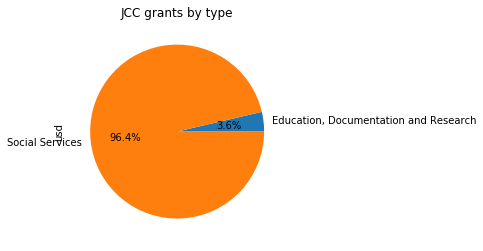

In [30]:
import matplotlib.pyplot as plt

jcc_table.groupby(by='Type')['Type', 'usd'].sum().plot.pie(y='usd', title='JCC grants by type',
                                                              autopct='%1.1f%%', legend=False)
plt.show()

#### Successor Organization

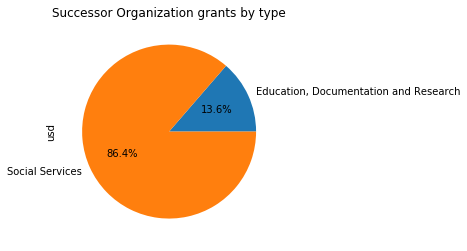

In [31]:
succorg_table.groupby(by='Type')['Type', 'usd'].sum().plot.pie(y='usd', title='Successor Organization grants by type',
                                                              autopct='%1.1f%%', legend=False)
plt.show()

#### Grants for education, documentation and research by fund

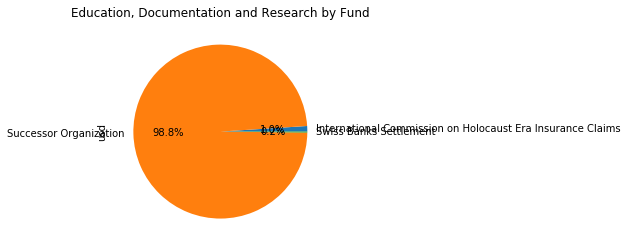

Fund
Successor Organization                                       67,392,274.14
International Commission on Holocaust Era Insurance Claims      698,766.00
Swiss Banks Settlement                                          125,000.00
Name: usd, dtype: float64

In [32]:
jcc_table.where(jcc_table['Type']=='Education, Documentation and Research').dropna().groupby(by='Fund')['usd'].sum().plot.pie(y='usd', title='Education, Documentation and Research by Fund', autopct='%1.1f%%', legend=False)
plt.show()
jcc_table.where(jcc_table['Type']=='Education, Documentation and Research').dropna().groupby(by='Fund')['usd'].sum().sort_values(ascending=False)

### Education, documentation and research grants in Israel

In [33]:
jcc_table.where((jcc_table['Type']=='Education, Documentation and Research') & (jcc_table['Country']=='Israel')).dropna().groupby(by='Institution')['usd'].sum().sort_values()

Institution
Clemantina Films                                                                                 3,611.11
Organization of Zhetel Survivors and their Families                                              6,431.70
Maya Zack                                                                                        7,693.00
Hitachdut Yotzei Czechoslovakia                                                                  9,833.73
Wilfrid Israel Association for Art and Oriental Studies                                         12,152.00
Hebrew University of Jerusalem - Center for Multimedia Assisted Instruction                     12,152.00
Beer Yaakov Mental Health Center                                                                12,576.86
Leo Baeck Institute (Jerusalem)                                                                 14,352.00
Makor Foundation for Cinema and Television Films                                                14,582.00
The New Foundation for Cinema and 

#### Specific grants

In [34]:
jcc_table.where(jcc_table['Institution'] == 'Birthright Israel').dropna()

,Type,Fund,Institution,City,State,Country,Grant,Purpose,year,currency,grant_sum,conversion_rate,usd
287,"Education, Documentation and Research",Successor Organization,Birthright Israel,Jerusalem,,Israel,"$18,814",Toward the Holocaust education component of th...,"2,016.00",USD,"18,814.00",1.00,"18,814.00"
316,"Education, Documentation and Research",Successor Organization,Birthright Israel,Jerusalem,,Israel,"₪525,000",Toward including a structured Holocaust seminar.,"2,014.00",ILS,"525,000.00",3.58,"146,730.02"


In [35]:
jcc_table.to_csv('jcc_table.csv')